## 1. Importação de bibliotecas e carregamento de dados

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import classification_report


# Carregando os dados
caminho_dados = '../Dados_Treino_Teste'
X_treino = pd.read_csv(f'{caminho_dados}/X_treino.csv')
X_teste = pd.read_csv(f'{caminho_dados}/X_teste.csv')
y_treino = pd.read_csv(f'{caminho_dados}/y_treino.csv').squeeze()
y_teste = pd.read_csv(f'{caminho_dados}/y_teste.csv').squeeze()

## 2. Treinamento do modelo Regressão Logistica

In [11]:

# Treinamento do modelo base
modelo_logistico = LogisticRegression(max_iter=1000)
modelo_logistico.fit(X_treino, y_treino)

# Predições no conjunto de teste
y_pred_teste = modelo_logistico.predict(X_teste)

# Avaliação do desempenho
print(f"Acurácia:  {accuracy_score(y_teste, y_pred_teste):.4f}")
print(f"Precisão:  {precision_score(y_teste, y_pred_teste, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_teste, y_pred_teste, zero_division=0):.4f}")
print(f"F1-score:  {f1_score(y_teste, y_pred_teste, zero_division=0):.4f}")



Acurácia:  0.8944
Precisão:  0.9232
Recall:    0.8875
F1-score:  0.9050


## 3. Matriz de Confusão

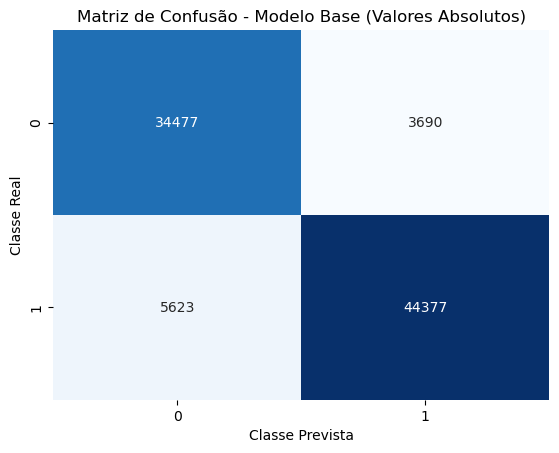

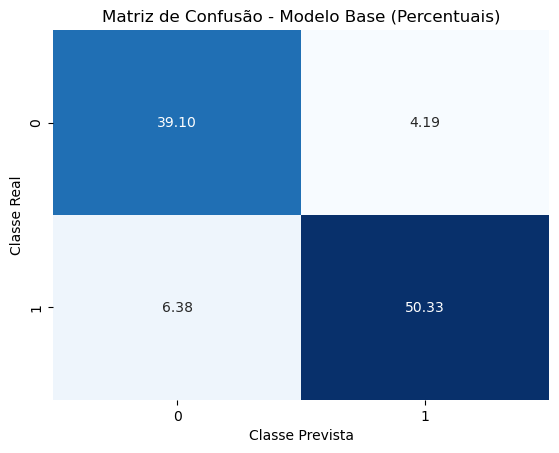

Matriz de Confusão - Interpretação:
→ Verdadeiros Negativos (TN): 34477
→ Falsos Positivos (FP): 3690
→ Falsos Negativos (FN): 5623
→ Verdadeiros Positivos (TP): 44377

Interpretação:
- O modelo acertou 44377 casos de cancelamento e 34477 casos de não cancelamento.
- Ele errou em 3690 casos ao prever cancelamento onde não houve (falsos positivos).
- Cometeu 5623 erros ao deixar de prever cancelamentos que ocorreram (falsos negativos).
- Falsos negativos são particularmente importantes, pois indicam clientes que cancelaram sem serem previstos pelo modelo.


In [13]:

# Calcula matriz de confusão e matriz normalizada (percentual)
cm = confusion_matrix(y_teste, y_pred_teste)
cm_normalizado = cm / cm.sum() * 100

# Plot - valores absolutos
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão - Modelo Base (Valores Absolutos)")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()

# Plot - percentuais
sns.heatmap(cm_normalizado, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão - Modelo Base (Percentuais)")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()

# Explicação textual da matriz de confusão
tn, fp, fn, tp = cm.ravel()

print("Matriz de Confusão - Interpretação:")
print(f"→ Verdadeiros Negativos (TN): {tn}")
print(f"→ Falsos Positivos (FP): {fp}")
print(f"→ Falsos Negativos (FN): {fn}")
print(f"→ Verdadeiros Positivos (TP): {tp}")

print("\nInterpretação:")
print(f"- O modelo acertou {tp} casos de cancelamento e {tn} casos de não cancelamento.")
print(f"- Ele errou em {fp} casos ao prever cancelamento onde não houve (falsos positivos).")
print(f"- Cometeu {fn} erros ao deixar de prever cancelamentos que ocorreram (falsos negativos).")
print("- Falsos negativos são particularmente importantes, pois indicam clientes que cancelaram sem serem previstos pelo modelo.")


## 4. Curva ROC

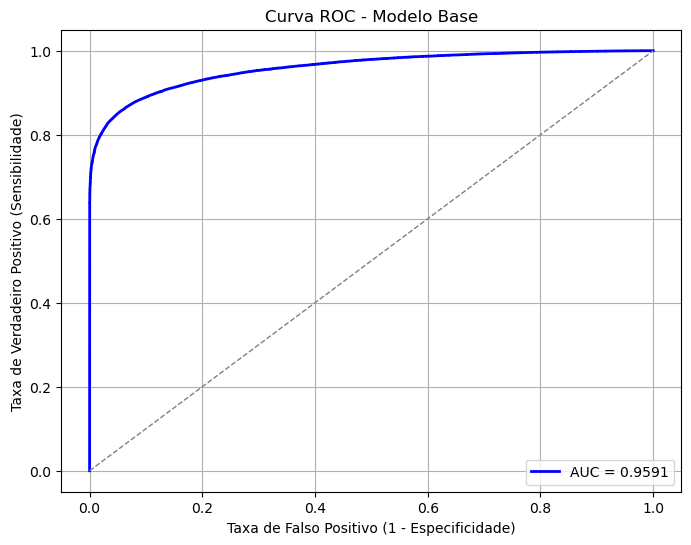

Interpretação da Curva ROC:
- A curva ROC mostra a relação entre a Sensibilidade (TPR) e a Especificidade (1 - FPR) para vários thresholds de decisão.
- O valor AUC (Área Sob a Curva) é 0.9591, indicando a capacidade do modelo de distinguir entre as classes.
- Excelente desempenho: modelo altamente discriminativo.
- Quanto mais próximo de 1, melhor o modelo. Um valor próximo a 0.5 indica um modelo aleatório.


In [14]:

# Probabilidades preditas para a classe positiva
y_proba = modelo_logistico.predict_proba(X_teste)[:, 1]

# Calcula taxas de falso positivo e verdadeiro positivo para diferentes thresholds
fpr, tpr, thresholds = roc_curve(y_teste, y_proba)

# Calcula área sob a curva ROC
auc_score = roc_auc_score(y_teste, y_proba)

# Plot da curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("Taxa de Falso Positivo (1 - Especificidade)")
plt.ylabel("Taxa de Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC - Modelo Base")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Interpretação detalhada da curva ROC
print("Interpretação da Curva ROC:")
print(f"- A curva ROC mostra a relação entre a Sensibilidade (TPR) e a Especificidade (1 - FPR) para vários thresholds de decisão.")
print(f"- O valor AUC (Área Sob a Curva) é {auc_score:.4f}, indicando a capacidade do modelo de distinguir entre as classes.")
if auc_score > 0.9:
    print("- Excelente desempenho: modelo altamente discriminativo.")
elif auc_score > 0.8:
    print("- Bom desempenho: modelo com boa capacidade discriminativa.")
elif auc_score > 0.7:
    print("- Desempenho razoável: modelo com capacidade moderada.")
else:
    print("- Desempenho fraco: modelo com pouca capacidade de discriminação.")
print("- Quanto mais próximo de 1, melhor o modelo. Um valor próximo a 0.5 indica um modelo aleatório.")


## 5. Previsão de quantidades (cancelamentos e não cancelamentos)

In [16]:
total_predicoes = len(y_pred_teste)
cancelamentos = np.sum(y_pred_teste == 1)
nao_cancelamentos = np.sum(y_pred_teste == 0)

print("\nPrevisão de Quantidades:")
print(f"Total de Previsões: {total_predicoes}")
print(f"Cancelamentos previstos: {cancelamentos} ({cancelamentos / total_predicoes * 100:.2f}%)")
print(f"Não cancelamentos previstos: {nao_cancelamentos} ({nao_cancelamentos / total_predicoes * 100:.2f}%)")



Previsão de Quantidades - Modelo Base:
Total de Previsões: 88167
Cancelamentos previstos: 48067 (54.52%)
Não cancelamentos previstos: 40100 (45.48%)


## 6. Validação cruzada com múltiplas métricas

In [17]:
from scipy import stats

print("\nValidação Cruzada:")

for metrica in metricas:
    scores = resultado[f'test_{metrica}']
    media = np.mean(scores)
    desvio = np.std(scores)
    # Calcula intervalo de confiança 95%
    ic = stats.t.interval(0.95, len(scores)-1, loc=media, scale=stats.sem(scores))
    print(f"{metrica.capitalize():<10} - Média: {media:.4f}, Desvio: {desvio:.4f}, IC 95%: ({ic[0]:.4f}, {ic[1]:.4f})")



Validação Cruzada - Modelo Base:
Accuracy   - Média: 0.8953, Desvio: 0.0009, IC 95%: (0.8942, 0.8965)
Precision  - Média: 0.9251, Desvio: 0.0012, IC 95%: (0.9234, 0.9268)
Recall     - Média: 0.8873, Desvio: 0.0009, IC 95%: (0.8861, 0.8885)
F1         - Média: 0.9058, Desvio: 0.0007, IC 95%: (0.9048, 0.9068)


## 7. Avaliação no conjunto de treino

In [18]:
from sklearn.metrics import classification_report

# Previsões no treino e teste 
y_pred_train = modelo_logistico.predict(X_treino)
y_pred_teste = modelo_logistico.predict(X_teste)

print("\nAvaliação no Conjunto de TREINO - Modelo Base:")
print(f"Acurácia:    {accuracy_score(y_treino, y_pred_train):.4f}")
print(f"Precisão:    {precision_score(y_treino, y_pred_train, zero_division=0):.4f}")
print(f"Recall:      {recall_score(y_treino, y_pred_train, zero_division=0):.4f}")
print(f"F1-score:    {f1_score(y_treino, y_pred_train, zero_division=0):.4f}")

print("\nRelatório Completo (por classe):")
print(classification_report(y_treino, y_pred_train, zero_division=0))

# Calcula as métricas no treino
acc_train = accuracy_score(y_treino, y_pred_train)
prec_train = precision_score(y_treino, y_pred_train, zero_division=0)
rec_train = recall_score(y_treino, y_pred_train, zero_division=0)
f1_train = f1_score(y_treino, y_pred_train, zero_division=0)

# Calcula as métricas no teste
acc_test = accuracy_score(y_teste, y_pred_teste)
prec_test = precision_score(y_teste, y_pred_teste, zero_division=0)
rec_test = recall_score(y_teste, y_pred_teste, zero_division=0)
f1_test = f1_score(y_teste, y_pred_teste, zero_division=0)

print("\nComparação das Métricas - Treino x Teste:")
print(f"{'Métrica':<10} {'Treino':>10} {'Teste':>10} {'Diferença':>12}")
print("-" * 40)
for nome, tr, ts in zip(
    ["Acurácia", "Precisão", "Recall", "F1-score"],
    [acc_train, prec_train, rec_train, f1_train],
    [acc_test, prec_test, rec_test, f1_test],
):
    diff = tr - ts
    print(f"{nome:<10} {tr:10.4f} {ts:10.4f} {diff:12.4f}")

limite_diff = 0.1  # ajuste conforme necessidade

if any(abs(tr - ts) > limite_diff for tr, ts in zip(
    [acc_train, prec_train, rec_train, f1_train],
    [acc_test, prec_test, rec_test, f1_test],
)):
    print("\nATENÇÃO: Diferença alta entre treino e teste pode indicar OVERFITTING.")
else:
    print("\nModelo aparentemente generaliza bem entre treino e teste.")



Avaliação no Conjunto de TREINO - Modelo Base:
Acurácia:    0.8956
Precisão:    0.9255
Recall:      0.8874
F1-score:    0.9060

Relatório Completo (por classe):
              precision    recall  f1-score   support

           0       0.86      0.91      0.88    152666
           1       0.93      0.89      0.91    199999

    accuracy                           0.90    352665
   macro avg       0.89      0.90      0.89    352665
weighted avg       0.90      0.90      0.90    352665


Comparação das Métricas - Treino x Teste:
Métrica        Treino      Teste    Diferença
----------------------------------------
Acurácia       0.8956     0.8944       0.0012
Precisão       0.9255     0.9232       0.0023
Recall         0.8874     0.8875      -0.0002
F1-score       0.9060     0.9050       0.0010

Modelo aparentemente generaliza bem entre treino e teste.


## 8. Importância das variaveis

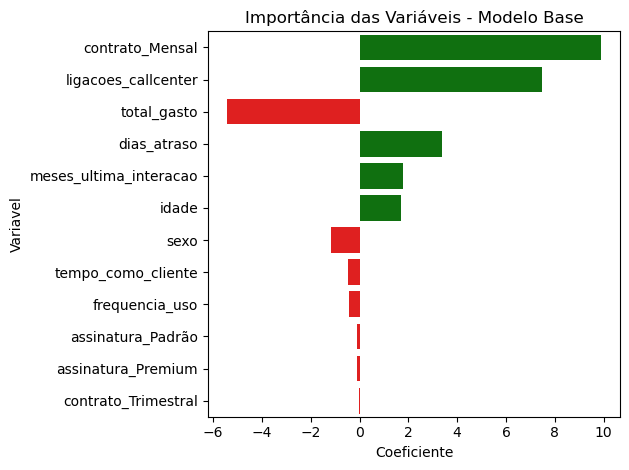

In [21]:
coef = modelo_logistico.coef_[0]
variaveis = X_treino.columns
importancia = pd.Series(coef, index=variaveis).sort_values(key=abs, ascending=False)

# Criar coluna categórica para cor (positivos/negativos)
df_importancia = importancia.reset_index()
df_importancia.columns = ['Variavel', 'Coeficiente']
df_importancia['Tipo'] = df_importancia['Coeficiente'].apply(lambda x: 'Positivo' if x >= 0 else 'Negativo')

sns.barplot(
    x='Coeficiente', 
    y='Variavel', 
    data=df_importancia,
    hue='Tipo',
    dodge=False,
    palette={'Positivo': 'green', 'Negativo': 'red'},
    legend=False  
)
plt.title("Importância das Variáveis - Modelo Base")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()

In [31]:
import joblib

# Salvar o modelo treinado
joblib.dump(modelo_logistico, 'modelo_Regressao_Logistica.pkl')

# Carregar o modelo treinado
modelo_carregado = joblib.load('modelo_Regressao_Logistica.pkl')


In [ ]:
sns.heatmap(confusion_matrix(y_teste, y_pred_otim), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - Modelo Otimizado")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()


## resultados

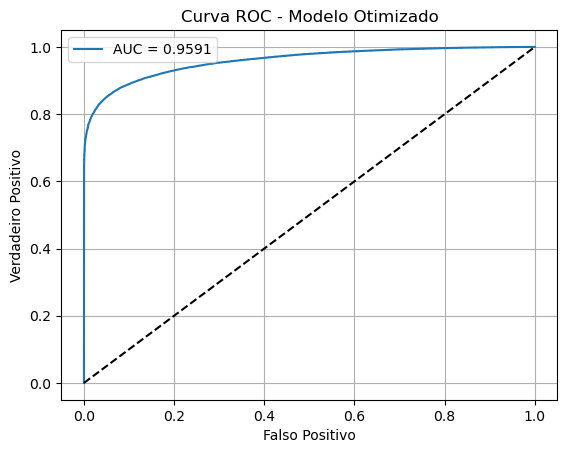

In [30]:
y_proba_otim = modelo_otimizado.predict_proba(X_teste)[:, 1]
fpr_otim, tpr_otim, _ = roc_curve(y_teste, y_proba_otim)
auc_otim = roc_auc_score(y_teste, y_proba_otim)

plt.plot(fpr_otim, tpr_otim, label=f"AUC = {auc_otim:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC - Modelo Otimizado")
plt.legend()
plt.grid()
plt.show()

### Desempenho do Modelo de Regressão Logística

O modelo apresentou uma acurácia de 89,44% no conjunto de teste, indicando que ele classificou corretamente quase 9 em cada 10 clientes em relação ao cancelamento.  

A matriz de confusão mostra que o modelo identificou corretamente 44.377 casos de cancelamento e 34.477 casos de não cancelamento.


In [ ]:
resultado_otim = cross_validate(modelo_otimizado, X_full, y_full, cv=5, scoring=metricas)

print("\nValidação Cruzada - Modelo Otimizado:")
for metrica in metricas:
    media = np.mean(resultado_otim[f'test_{metrica}'])
    desvio = np.std(resultado_otim[f'test_{metrica}'])
    print(f"{metrica.capitalize()} - Média: {media:.4f}, Desvio: {desvio:.4f}")

In [26]:

metricas = {
    "Métrica": ["Acurácia", "Precisão", "Recall", "F1-score", "AUC (ROC)"],
    "Valor": ["89,44%", "92,32%", "88,75%", "90,50%", "0,9591"]
}

df_metricas = pd.DataFrame(metricas)
display(df_metricas)


,Métrica,Valor
0,Acurácia,"89,44%"
1,Precisão,"92,32%"
2,Recall,"88,75%"
3,F1-score,"90,50%"
4,AUC (ROC),"0,9591"
